In [1]:
from itertools import product
from functools import partial
import pickle
import os

from nimare.generate import create_coordinate_dataset
from nimare.meta import ALE
from nimare.meta import KDA, MKDADensity
from nimare.meta import KDAKernel, ALEKernel, MKDAKernel
from nimare.correct import FDRCorrector, FWECorrector

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from joblib import Parallel, delayed
import scipy


ERROR:duecredit:Failed to import duecredit due to No module named 'duecredit'


In [2]:
N_DSET = 100
N_JOBS = os.cpu_count()
OVERWRITE_DSETS = True
DSET_FILE = "test_dsets.pkl"

In [3]:
# get parameters for experiment generation
peaks_per_exp_dist = scipy.stats.exponnorm(6.7540609200317, 2.158865654395452, 1.1158058948483953)
participants_per_exp_dist = scipy.stats.skewnorm(7.881356479848355, 4.688142922191945, 13.846879591002242)
peaks_per_exp_low_high = (int(peaks_per_exp_dist.ppf(0.05)), int(peaks_per_exp_dist.ppf(0.95)))
part_per_exp_low_high = (int(participants_per_exp_dist.ppf(0.05)), int(participants_per_exp_dist.ppf(0.95)))
num_of_exp_low_high = (20, 100)

In [4]:
def create_dsets(n_dsets, **kwargs):
    partial_ccd = partial(create_coordinate_dataset, **kwargs)
    # just return the dset output since there are no signal foci
    return [dset for foci, dset in Parallel(n_jobs=N_JOBS)(delayed(partial_ccd)(**{'seed': seed}) for seed in range(n_dsets))]



In [5]:
if OVERWRITE_DSETS or not os.path.isfile(DSET_FILE):
    dset_params = product(peaks_per_exp_low_high, part_per_exp_low_high, num_of_exp_low_high)
    dset_dict = {}
    for foci, participants, studies in dset_params:
        key = f"foci-{foci}_participants-{participants}_studies-{studies}"
        dset_dict[key] = create_dsets(N_DSET, foci=0, n_noise_foci=foci, sample_size=participants, n_studies=studies)
    with open(DSET_FILE, "wb") as pkl_file:
        pickle.dump(dset_dict, pkl_file)
else:
    with open(DSET_FILE, "rb") as pkl_file:
        dset_dict = pickle.load(pkl_file)


In [11]:
# set up the meta analysis estimators
metas = [
    ('ale', ALE),
    ('mkda', MKDADensity),
]

null_methods = [
    {'null_method': 'analytic'},
    {'null_method': 'empirical'},
]

dset_examples = [(params, dsets[0]) for params, dsets in dset_dict.items()]
fit_dset_args = list(product(metas, dset_examples, null_methods))

def fit_dset(meta_tuple, dset_tuple, kwargs):
    res = meta_tuple[1](**kwargs).fit(dset_tuple[1])
    p_map = res.get_map("p", return_type="array")
    fpr = (p_map < 0.05).sum() / p_map.shape[0]
    return meta_tuple[0], dset_tuple[0], kwargs['null_method'], fpr, p_map


In [12]:
estimator_results = Parallel(n_jobs=N_JOBS)(delayed(fit_dset)(*args) for args in fit_dset_args)

In [13]:
estimator_collector = {'meta': [], 'dset': [], 'null_method': [], "fpr": [], "p_array": []}
for res in estimator_results:
    estimator_collector['meta'].append(res[0])
    estimator_collector['dset'].append(res[1])
    estimator_collector['null_method'].append(res[2])
    estimator_collector['fpr'].append(res[3])
    estimator_collector['p_array'].append(res[4])

In [14]:
estimator_df = pd.DataFrame(estimator_collector)

In [24]:
estimator_df.query("meta == 'ale'")

meta                                 dset null_method       fpr  \
0   ale     foci-2_participants-5_studies-20    analytic  0.052444   
1   ale     foci-2_participants-5_studies-20   empirical  0.050045   
2   ale    foci-2_participants-5_studies-100    analytic  0.052891   
3   ale    foci-2_participants-5_studies-100   empirical  0.051105   
4   ale    foci-2_participants-31_studies-20    analytic  0.050492   
5   ale    foci-2_participants-31_studies-20   empirical  0.046657   
6   ale   foci-2_participants-31_studies-100    analytic  0.048631   
7   ale   foci-2_participants-31_studies-100   empirical  0.052593   
8   ale    foci-24_participants-5_studies-20    analytic  0.054423   
9   ale    foci-24_participants-5_studies-20   empirical  0.056226   
10  ale   foci-24_participants-5_studies-100    analytic  0.069826   
11  ale   foci-24_participants-5_studies-100   empirical  0.061816   
12  ale   foci-24_participants-31_studies-20    analytic  0.051271   
13  ale   foci-24_participants-31_studies-20   empirical  0.050321   
14  ale  foci-24_participants-31_studies-100    analytic  0.058183   
15  ale  foci-24_participants-31_studies-100   empirical  0.052860   

                                              p_array  
0   [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...  
1   [0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.999...  
2   [1.0, 0.8469864068302272, 0.8469864068302272, ...  
3   [0.9008, 0.87, 0.842, 0.9031, 0.8727, 0.9419, ...  
4   [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...  
5   [0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.999...  
6   [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...  
7   [0.8913, 0.8578, 0.8319, 0.8941, 0.8631, 0.926...  
8   [0.2535266168650127, 0.22144336927099595, 0.25...  
9   [0.2481, 0.2178, 0.24650000000000005, 0.2187, ...  
10  [0.7607284118785692, 0.7273356672592303, 0.758...  
11  [0.7894, 0.7558, 0.786, 0.6995, 0.6717, 0.7604...  
12  [0.1712678224868031, 0.14324057957955566, 0.17...  
13  [0.1765000000000001, 0.1451, 0.175799999999999...  
14  [0.6243466421461424, 0.5614519556643147, 0.608...  
15  [0.6223000000000001, 0.5627, 0.6077, 0.5118, 0...

In [15]:
ale_analytic = estimator_df.query("meta == 'ale' & null_method == 'analytic'")['p_array'].values
ale_empirical = estimator_df.query("meta == 'ale' & null_method == 'empirical'")['p_array'].values
ale_correlations = np.array([np.corrcoef(analytic, empirical)[0][1] for analytic, empirical in zip(ale_analytic, ale_empirical)])

In [16]:
ale_correlations.mean()

0.9437427575133117

In [17]:
mkda_analytic = estimator_df.query("meta == 'mkda' & null_method == 'analytic'")['p_array'].values
mkda_empirical = estimator_df.query("meta == 'mkda' & null_method == 'empirical'")['p_array'].values
mkda_correlations = np.array([np.corrcoef(analytic, empirical)[0][1] for analytic, empirical in zip(mkda_analytic, mkda_empirical)])

In [18]:
mkda_correlations.mean()

0.9999846097538928

In [19]:
ale_mkda_correlations = np.array([np.corrcoef(ale, mkda)[0][1] for ale, mkda in zip(ale_analytic, mkda_analytic)])

Text(0.5, 1.0, 'False Positive Rates for Meta Analysis Estimators')

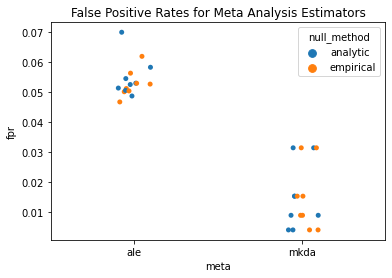

In [20]:
fig = sns.stripplot(data=estimator_df, x='meta', hue='null_method', y='fpr')
fig.set_title("False Positive Rates for Meta Analysis Estimators")

In [25]:
long_df = estimator_df.query("dset == 'foci-24_participants-5_studies-100'").explode('p_array')

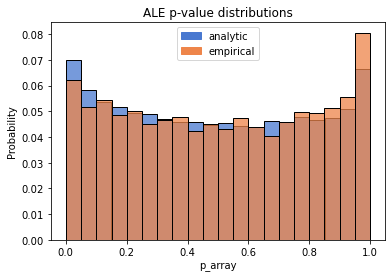

In [26]:
fig, ax = plt.subplots()
sns.histplot(
    data=long_df.query("meta == 'ale' & null_method == 'analytic'"),
    x="p_array",
    bins=20,
    ax=ax,
    color=sns.color_palette("muted")[0],
    stat="probability",
)
sns.histplot(
    data=long_df.query("meta == 'ale' and null_method == 'empirical'"),
    x="p_array",
    bins=20,
    ax=ax,
    color=sns.color_palette("muted")[1],
    stat="probability",
)
ax.legend(
    handles=[
        mpatches.Patch(color=sns.color_palette("muted")[0], label="analytic"),
        mpatches.Patch(color=sns.color_palette("muted")[1], label="empirical"),
    ]
);
ax.set_title("ALE p-value distributions");

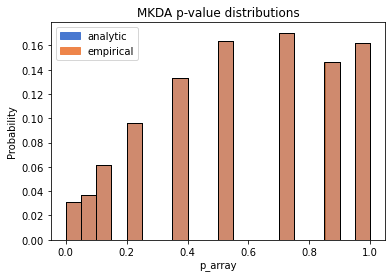

In [27]:
fig, ax = plt.subplots()
sns.histplot(
    data=long_df.query("meta == 'mkda' & null_method == 'analytic'"),
    x="p_array",
    bins=20,
    ax=ax,
    color=sns.color_palette("muted")[0],
    stat="probability",
)
sns.histplot(
    data=long_df.query("meta == 'mkda' and null_method == 'empirical'"),
    x="p_array",
    bins=20,
    ax=ax,
    color=sns.color_palette("muted")[1],
    stat="probability",
)
ax.legend(
    handles=[
        mpatches.Patch(color=sns.color_palette("muted")[0], label="analytic"),
        mpatches.Patch(color=sns.color_palette("muted")[1], label="empirical"),
    ]
);
ax.set_title("MKDA p-value distributions");

Text(0.5, 1.0, 'ALE Empirical/Analytic Correlation')

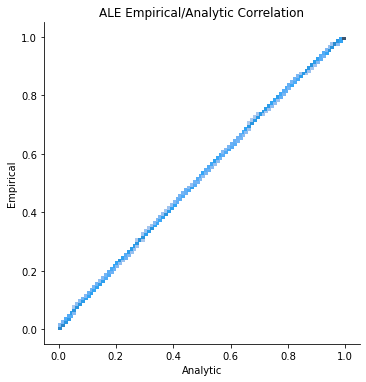

In [28]:
g = sns.displot(
    kind="hist",
    bins=100,
    x=long_df.query("meta == 'ale' & null_method == 'analytic'")['p_array'].values,
    y=long_df.query("meta == 'ale' & null_method == 'empirical'")["p_array"].values,
    rug=False,
)
g.axes[0][0].set_xlabel("Analytic");
g.axes[0][0].set_ylabel("Empirical");
g.axes[0][0].set_title("ALE Empirical/Analytic Correlation")

Text(0.5, 1.0, 'MKDA Empirical/Analytic Correlation')

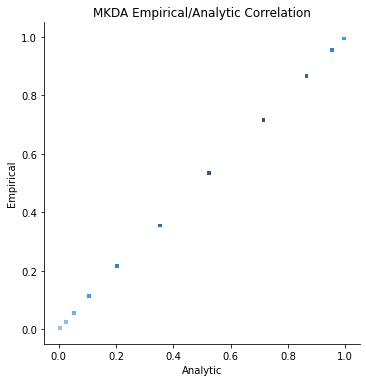

In [29]:
g = sns.displot(
    kind="hist",
    bins=100,
    x=long_df.query("meta == 'mkda' & null_method == 'analytic'")['p_array'].values,
    y=long_df.query("meta == 'mkda' & null_method == 'empirical'")["p_array"].values,
    rug=False,
)
g.axes[0][0].set_xlabel("Analytic");
g.axes[0][0].set_ylabel("Empirical");
g.axes[0][0].set_title("MKDA Empirical/Analytic Correlation")

In [49]:
# test empirical methods across all dsets
metas = [
    ('ale', ALE),
    ('mkda', MKDADensity),
]

null_methods = [
    {'null_method': 'analytic'},
]

dset_examples = [
    (idx, params, dset) for idx, (params, dsets) in enumerate(dset_dict.items())
    for dset in dsets[0:5]
]
fit_dset_args = list(product(metas, dset_examples, null_methods))

def fit_dset(meta_tuple, dset_tuple, kwargs):
    res = meta_tuple[1](**kwargs).fit(dset_tuple[2])
    p_map = res.get_map("p", return_type="array")
    fpr = (p_map < 0.05).sum() / p_map.shape[0]
    return meta_tuple[0], dset_tuple[0], dset_tuple[1], kwargs['null_method'], fpr, p_map


In [50]:
fit_dset_args

[(('ale', nimare.meta.cbma.ale.ALE),
  (0,
   'foci-2_participants-5_studies-20',
   <nimare.dataset.Dataset at 0x7fee1b2c0390>),
  {'null_method': 'analytic'}),
 (('ale', nimare.meta.cbma.ale.ALE),
  (0,
   'foci-2_participants-5_studies-20',
   <nimare.dataset.Dataset at 0x7fee1b2ca390>),
  {'null_method': 'analytic'}),
 (('ale', nimare.meta.cbma.ale.ALE),
  (0,
   'foci-2_participants-5_studies-20',
   <nimare.dataset.Dataset at 0x7fee1b2cc048>),
  {'null_method': 'analytic'}),
 (('ale', nimare.meta.cbma.ale.ALE),
  (0,
   'foci-2_participants-5_studies-20',
   <nimare.dataset.Dataset at 0x7fee1b2ca2e8>),
  {'null_method': 'analytic'}),
 (('ale', nimare.meta.cbma.ale.ALE),
  (0,
   'foci-2_participants-5_studies-20',
   <nimare.dataset.Dataset at 0x7fee1b26a3c8>),
  {'null_method': 'analytic'}),
 (('ale', nimare.meta.cbma.ale.ALE),
  (1,
   'foci-2_participants-5_studies-100',
   <nimare.dataset.Dataset at 0x7fee1adc6cc0>),
  {'null_method': 'analytic'}),
 (('ale', nimare.meta.cbma.

In [52]:
estimator_results = Parallel(n_jobs=N_JOBS)(delayed(fit_dset)(*args) for args in fit_dset_args)
estimator_collector = {'meta': [], 'dset': [], 'foci': [], 'studies': [], 'participants': [], 'null_method': [], "fpr": [], "p_array": []}
for res in estimator_results:
    foci, participants, studies = [attr.split('-')[1] for attr in res[2].split('_')]
    estimator_collector['foci'].append(foci)
    estimator_collector['studies'].append(studies)
    estimator_collector['participants'].append(participants)
    estimator_collector['meta'].append(res[0])
    estimator_collector['dset'].append(res[1])
    estimator_collector['null_method'].append(res[3])
    estimator_collector['fpr'].append(res[4])
    estimator_collector['p_array'].append(res[5])

In [53]:
estimator_full_df = pd.DataFrame(estimator_collector)

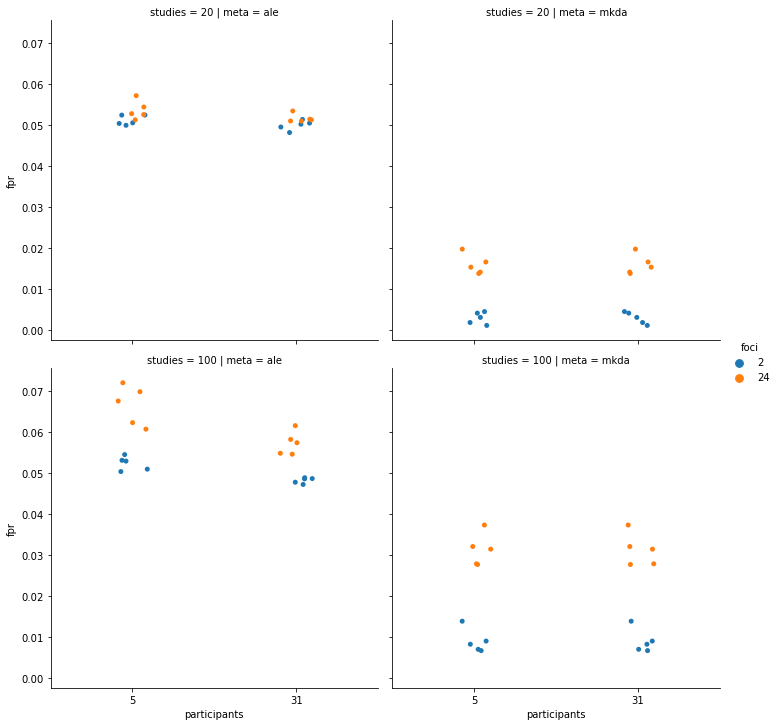

In [57]:
sns.catplot(x='participants', y='fpr', hue='foci', row='studies', col='meta', data=estimator_full_df)

In [ ]:
# observations:
# - increasing the number of noise foci increases false positive rate (but does not make much difference for ALE when number of studies is low)
# - increasing the number of studies increases false positive rate
# - increasing number of participants per study impacts ALE when number of studies is large
# - ale is more liberal than mkda